# ING Insights


Notebook used to categorize and automatically analyse transations data from ING Bank Account. This account is aggregation transaction information from all accounts in ING Bank as well as Millennium.

Analysis should be used to aggregate per month infomrations infomrations about spending, mainly from accounts `Wspólne`, `Osobiste`, `Millennium`.


**TODO**
- [ ] Export to Excel
- [ ] Different data analysis options

## 01 - Importing data

Import data from ING Bank history export. Class used to import the data `TransactionDataLoader` consisting fetching mechanism with data sanitization finctionalities.

In [153]:
from pathlib import Path

from data_loader import *

csv_import_1 = Path("data/Lista_transakcji_nr_0202366310_201224.csv")
csv_import_2 = Path("data/20241220_lista_transkcji_ing_mill_90.csv")
csv_import_3 = Path("data/Lista_transakcji_nr_0202026071_161224_ING_MILL.csv")

df = TransactionDataLoader(csv_import_1).get_data()
print(f"Successfully imported dataframe with size {df.shape}\n\n")



Successfully imported dataframe with size (240, 21)




## 02 - Data filtering and sanitization


Filter only usefully columns for further data analysis. This will be the base for further analysis of data.


In [154]:
selected_columns = ['Data transakcji', 'Dane kontrahenta', 'Tytuł', 'Kwota transakcji (waluta rachunku)', 'Bank']
f_df = df[selected_columns]


## 03 - Categorization


Define categories for analysis and fill the data based on filter definition applied to `Dane kontrachenta` in `f_df` data frame.


In [155]:
"""
Input data for analysis: f_df
"""

#ExpenceCategiries instance containing objects of expense category.
expense_category_list = [
    ExpenseCategory(name="Zakupy spożywcze", filter="LIDL|BIED|ZAB|PIEKARNIA"),
    ExpenseCategory(name="Kosmetyki", filter="ROSSMANN|notino"),
    ExpenseCategory(name="Restauracje", filter="PIAZZA|COCKPEAT|CHLEBOTEKA|WHISKEYINTHEJAR|TUTTI")
]

# Filter f_df dataframe and fill each ExpenseCategory data class attributes.
for i in range(len(expense_category_list)):
    expense_category_list[i].data_frame = f_df[
        f_df["Dane kontrahenta"].str.contains(expense_category_list[i].filter) == True]

    expense_category_list[i].sum = abs(
        round(float(expense_category_list[i].data_frame["Kwota transakcji (waluta rachunku)"].sum()), 2))

Transform `expense_category_list` to data frame.

In [156]:
from dataclasses import asdict

expense_dicts = [asdict(expense) for expense in expense_category_list]
temp_df = pd.DataFrame(expense_dicts)


Plot

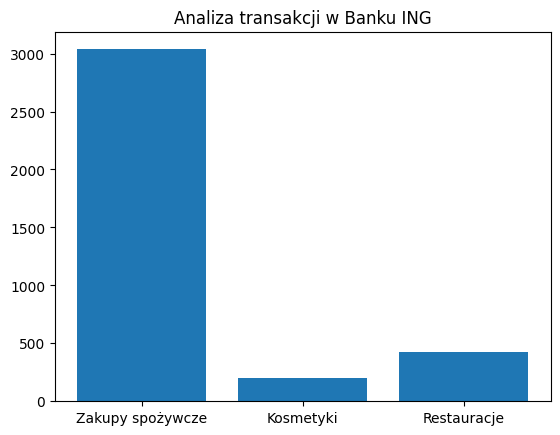

,name,sum
0,Zakupy spożywcze,3037.11
1,Kosmetyki,204.56
2,Restauracje,429.40


In [157]:
import matplotlib.pyplot as plt

# Plot the bar chart
bars = plt.bar(temp_df['name'], temp_df['sum'])

plt.title('Analiza transakcji w Banku ING')

# Show the plot
plt.show()

temp_df[['name', 'sum']]